In [1]:
# Zero DTE, entrada números redondos en el SPY el 0- DTE con un call o bull spread

In [2]:
# Intraday Gamma Scalping SPY
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import requests
import ivolatility as ivol
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [3]:
# venta de put
fichero = 'SPY_2024-04-15_0_0_P.csv'
df_full = pd.read_csv(f'input_zero_DTE/{fichero}', sep=',', parse_dates=['timestamp'])

# Select the desired columns to keep
columns_to_keep = ['timestamp', 'optionStrike', 'optionType', 'optionBidPrice', 'optionAskPrice', 
                   'underlyingPrice', 'optionIv', 'optionDelta', 'optionTheta']
df_P_ATM = df_full[columns_to_keep]

# Extract the date part from the first row's timestamp
fecha = df_P_ATM['timestamp'].iloc[0].date()

print(fecha)
df_full

2024-04-15


,timestamp,stockId,stockSymbol,optionExpirationDate,optionStrike,optionType,optionStyle,optionSymbol,optionBidPrice,optionAskPrice,optionBidDateTime,optionAskDateTime,optionBidSize,optionAskSize,optionBidExchange,optionAskExchange,optionVolume,optionIv,underlyingPrice,optionDelta,optionGamma,optionTheta,optionVega,optionRho,optionPreIv,optionImpliedYield,calcTimestamp,date
0,2024-04-15 09:30:00,627,SPY,2024-04-15,505.0,P,A,SPY 240415P00505000,0.62,0.63,2024-04-12 16:02:01,2024-04-12 16:02:01,167,343,PO,C2,0,0.1397,510.850,-0.17763,0.040209,-0.277214,0.12050,-0.00751,0.1397,0.000000,2024-04-15 09:25:58,2024-04-15
1,2024-04-15 09:31:00,627,SPY,2024-04-15,505.0,P,A,SPY 240415P00505000,0.04,0.05,2024-04-15 09:30:04,2024-04-15 09:30:04,776,5519,PO,PO,159,0.3589,515.070,-0.02335,0.010761,-0.503286,0.00789,-0.00009,0.3589,0.040008,2024-04-15 09:30:29,2024-04-15
2,2024-04-15 09:32:00,627,SPY,2024-04-15,505.0,P,A,SPY 240415P00505000,0.04,0.05,2024-04-15 09:31:42,2024-04-15 09:31:42,7779,7136,C2,C2,904,0.3529,514.850,-0.02374,0.011120,-0.502545,0.00798,-0.00009,0.3529,0.040008,2024-04-15 09:31:50,2024-04-15
3,2024-04-15 09:33:00,627,SPY,2024-04-15,505.0,P,A,SPY 240415P00505000,0.04,0.05,2024-04-15 09:32:20,2024-04-15 09:32:20,7886,7464,C2,C2,1062,0.3520,514.810,-0.02382,0.011187,-0.502934,0.00800,-0.00009,0.3520,0.040008,2024-04-15 09:32:29,2024-04-15
4,2024-04-15 09:34:00,627,SPY,2024-04-15,505.0,P,A,SPY 240415P00505000,0.04,0.05,2024-04-15 09:33:43,2024-04-15 09:33:43,6359,5491,C2,C2,1353,0.3485,514.670,-0.02408,0.011428,-0.503036,0.00805,-0.00010,0.3485,0.040008,2024-04-15 09:33:50,2024-04-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,2024-04-15 16:15:00,627,SPY,2024-04-15,504.0,P,A,SPY 240415P00504000,0.06,0.07,2024-04-15 16:14:33,2024-04-15 16:14:33,92,2,BT,Q,216138,4.0515,504.180,-0.45900,0.223818,-1279.270300,0.00174,-0.00000,-1.0000,0.040008,2024-04-15 16:14:39,2024-04-15
816,2024-04-15 16:16:00,627,SPY,2024-04-15,504.0,P,A,SPY 240415P00504000,0.08,0.09,2024-04-15 16:14:58,2024-04-15 16:15:00,8,41,MP,PO,216429,0.2249,504.180,0.00000,0.000000,0.000000,0.00000,0.00000,-1.0000,0.040008,2024-04-15 16:16:00,2024-04-15
817,2024-04-15 16:17:00,627,SPY,2024-04-15,504.0,P,A,SPY 240415P00504000,0.08,0.09,2024-04-15 16:14:58,2024-04-15 16:15:00,8,41,MP,PO,216429,0.2248,504.155,0.00000,0.000000,0.000000,0.00000,0.00000,-1.0000,0.040008,2024-04-15 16:16:39,2024-04-15
818,2024-04-15 16:18:00,627,SPY,2024-04-15,504.0,P,A,SPY 240415P00504000,0.08,0.09,2024-04-15 16:14:58,2024-04-15 16:15:00,8,41,MP,PO,216429,0.2248,504.155,0.00000,0.000000,0.000000,0.00000,0.00000,-1.0000,0.040008,2024-04-15 16:16:39,2024-04-15


Transposición del Dataframe según Strikes

In [4]:
import pandas as pd

# Assuming df_P_ATM has already been loaded and is available

# Pivot the dataframe for bid, ask prices, optionIv, and optionTheta for each strike
prices_iv_theta_spreads = df_P_ATM.pivot_table(index='timestamp', 
                                               columns='optionStrike', 
                                               values=['optionBidPrice', 'optionAskPrice', 'optionIv', 'optionTheta'],
                                               aggfunc='first')

# Simplify the multi-index in columns
prices_iv_theta_spreads.columns = ['_'.join([str(col[0]), str(int(col[1]))]) for col in prices_iv_theta_spreads.columns.values]

# Get underlyingPrice without repeating for each strike
underlying_price = df_P_ATM[['timestamp', 'underlyingPrice']].drop_duplicates('timestamp').set_index('timestamp')

# Combine the dataframes
df_P_spread = pd.concat([prices_iv_theta_spreads, underlying_price], axis=1)

# Reset index to bring timestamp back as a column
df_P_spread.reset_index(inplace=True)

# Round all numeric columns to 2 decimal places
numeric_cols = df_P_spread.select_dtypes(include=['float64', 'int']).columns
df_P_spread[numeric_cols] = df_P_spread[numeric_cols].round(2)

# Dynamically calculate the Put_Spread based on available optionBidPrice and optionAskPrice columns
bid_prices = [col for col in df_P_spread.columns if 'optionBidPrice' in col]
ask_prices = [col for col in df_P_spread.columns if 'optionAskPrice' in col]

if bid_prices and ask_prices:
    # Sort to get the maximum bid price and minimum ask price columns
    highest_bid = max(bid_prices, key=lambda x: int(x.split('_')[-1]))
    lowest_ask = min(ask_prices, key=lambda x: int(x.split('_')[-1]))

    # Check if specific columns exist before trying to use them
    if highest_bid in df_P_spread and lowest_ask in df_P_spread:
        df_P_spread['Put_Spread'] = df_P_spread[highest_bid] - df_P_spread[lowest_ask]

# Optionally reorder columns or further process df_P_spread as required
df_P_spread.tail(30)

,timestamp,optionAskPrice_504,optionAskPrice_505,optionBidPrice_504,optionBidPrice_505,optionIv_504,optionIv_505,optionTheta_504,optionTheta_505,underlyingPrice,Put_Spread
380,2024-04-15 15:50:00,0.13,0.43,0.12,0.42,0.40,0.35,-11.32,-14.08,505.14,0.29
381,2024-04-15 15:51:00,0.15,0.52,0.14,0.50,0.37,0.39,-10.81,-15.66,505.04,0.35
382,2024-04-15 15:52:00,0.19,0.63,0.18,0.62,0.36,0.34,-12.50,-13.88,504.70,0.43
383,2024-04-15 15:53:00,0.13,0.48,0.12,0.46,0.36,0.34,-11.08,-14.60,504.97,0.33
384,2024-04-15 15:54:00,0.17,0.60,0.16,0.58,0.34,0.31,-12.29,-12.82,504.66,0.41
385,2024-04-15 15:55:00,0.14,0.51,0.13,0.49,0.33,0.31,-11.08,-13.59,504.80,0.35
386,2024-04-15 15:56:00,0.10,0.42,0.09,0.41,0.34,0.30,-10.39,-13.89,504.91,0.31
387,2024-04-15 15:57:00,0.08,0.35,0.07,0.34,0.35,0.33,-10.02,-15.25,505.02,0.26
388,2024-04-15 15:58:00,0.08,0.39,0.07,0.37,0.30,0.30,-8.51,-14.30,504.89,0.29
389,2024-04-15 15:59:00,0.08,0.43,0.07,0.41,0.30,0.28,-9.21,-13.17,504.80,0.33


Graph the results

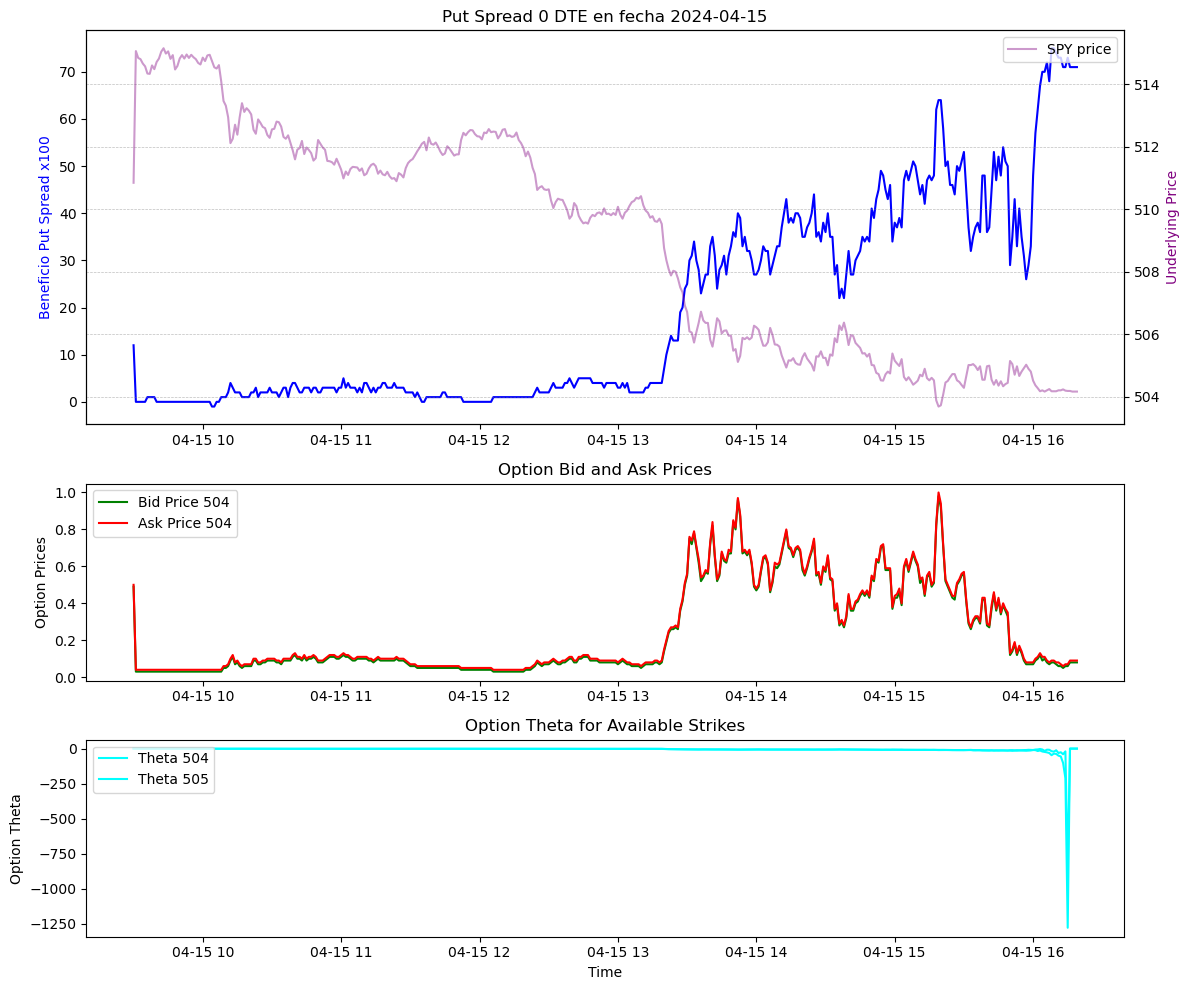

In [5]:
# Fetch the date from the first timestamp for use in the plot title
fecha = df_P_spread['timestamp'].iloc[0].strftime('%Y-%m-%d')

# Create a figure with specified figure size and three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1, 1]})

# Plotting Put_Spread and Underlying Price on the first subplot (ax1)
if 'Put_Spread' in df_P_spread.columns:
    ax1.plot(df_P_spread['timestamp'], df_P_spread['Put_Spread'] * 100, label='Put Spread', color='blue')
ax1_right = ax1.twinx()  # Create a second y-axis for the underlying price on the first subplot
ax1_right.plot(df_P_spread['timestamp'], df_P_spread['underlyingPrice'], label='SPY price', color='purple', linestyle='-', alpha=0.4)
ax1_right.set_ylabel('Underlying Price', color='purple')
ax1_right.legend(loc='upper right')
ax1.set_ylabel('Beneficio Put Spread x100', color='blue')
ax1.set_title(f'Put Spread 0 DTE en fecha {fecha}')

# Adding grid only for the underlying price axis
ax1_right.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='grey')

# Finding columns dynamically for optionBidPrice and optionAskPrice
bid_prices = [col for col in df_P_spread.columns if 'optionBidPrice' in col]
ask_prices = [col for col in df_P_spread.columns if 'optionAskPrice' in col]

# Plotting the first available bid and ask prices on the second subplot (ax2)
if bid_prices and ask_prices:
    ax2.plot(df_P_spread['timestamp'], df_P_spread[bid_prices[0]], label=f'Bid Price {bid_prices[0].split("_")[-1]}', color='green')
    ax2.plot(df_P_spread['timestamp'], df_P_spread[ask_prices[0]], label=f'Ask Price {ask_prices[0].split("_")[-1]}', color='red')
ax2.set_ylabel('Option Prices')
ax2.set_title('Option Bid and Ask Prices')
ax2.legend(loc='upper left')

# Finding columns dynamically for optionTheta
theta_columns = [col for col in df_P_spread.columns if 'optionTheta' in col]

# Plotting Theta values dynamically on the third subplot (ax3)
for theta in theta_columns:
    ax3.plot(df_P_spread['timestamp'], df_P_spread[theta], label=f'Theta {theta.split("_")[-1]}', color='orange' if '510' in theta else 'cyan')
ax3.set_xlabel('Time')
ax3.set_ylabel('Option Theta')
ax3.set_title('Option Theta for Available Strikes')
ax3.legend(loc='upper left')

# Show the plot
plt.tight_layout()  # Adjust layout so that labels do not overlap
plt.show()


In [6]:
import os
import subprocess

def notebook_to_script(notebook_name, repo_url):
    script_name = f"{notebook_name}.py"
    convert_command = f"jupyter nbconvert --to script {notebook_name}.ipynb"
    
    try:
        subprocess.run(convert_command, shell=True, check=True)
    except subprocess.CalledProcessError as e:
        print("Failed to convert notebook:", e.stderr.decode() if e.stderr else "No error details available.")
        return  # Exit if conversion fails

    if not os.path.exists('.git'):
        subprocess.run("git init", shell=True, check=True)

    # Ensure the main branch is created or switched to it if it exists
    subprocess.run("git checkout -B main", shell=True, check=True)
    
    # Check current remote URL
    existing_url = subprocess.run("git remote get-url origin", shell=True, capture_output=True, text=True)
    if existing_url.returncode == 0 and existing_url.stdout.strip() == repo_url:
        print("Remote 'origin' is already set to the correct URL.")
    else:
        if existing_url.returncode == 0:
            print("Remote 'origin' already exists, resetting to new URL")
            subprocess.run(f"git remote set-url origin {repo_url}", shell=True, check=True)
        else:
            print("Adding new remote 'origin'.")
            subprocess.run(f"git remote add origin {repo_url}", shell=True, check=True)

    subprocess.run(f"git add {script_name}", shell=True, check=True)
    
    # Check if there are any changes to commit
    status_result = subprocess.run("git status --porcelain", shell=True, capture_output=True, text=True)
    if status_result.stdout:
        commit_message = "Add script generated from Jupyter Notebook"
        subprocess.run(f'git commit -m "{commit_message}"', shell=True, check=True)
    else:
        print("No changes to commit.")
        return  # Exit if no changes

    # Push changes to the 'main' branch
    try:
        subprocess.run("git push -u origin main", shell=True, check=True)
    except subprocess.CalledProcessError as e:
        print("Failed to push to GitHub:", e.stderr.decode() if e.stderr else "No error details available.")

# Usage example uncommented for actual use
notebook_to_script('SPY_zero_DTE_v1', 'https://github.com/ferranfont/inter.git')


Remote 'origin' is already set to the correct URL.
Failed to push to GitHub: No error details available.
